# <center>Deep Lerning - Exercise Sheet 2

## <center>Suhas Kamuni <br> Prafful Gulati <br> Ceren Tüfekçi

# <center>Part 2 - 1

<ul>
<li>We started with the variational autoencoder (VAE) code from the Tutorial - 2.<br>
<li>From the practice part(part-2), we tried solving the 1st question which is train the  variational autoencoder (VAE) on the Fashion MNIST data set by depicting the reconstructed error and displaying the typical results of generated images.<br>
<li>We basically declare an empty list initially and then we append on every reconstructed image iterated in the for loop.<br>
<li>Below are the first 15 of the reconstructed images that we have extracted from the loop in the list.</ul>

In [14]:
import os.path
 
import numpy as np
import torch.utils.data
import torchvision.utils
from torch import nn, optim
from torch.nn import functional
from torchvision import datasets, transforms

# Variable to store list of reconstructed images
image_list = []
    
    
class VAE(nn.Module):
    def __init__( 
        self,
        input_shape,
        device,
        width,
        latent_dimensionality,
    ):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.n_input_values = np.prod(input_shape).item()
        self.device = device
        self.width = width
        self.latent_dimensionality = latent_dimensionality
 
        # Define encoding layers.
        self.input_encoder = nn.Linear(
            self.n_input_values, self.width
        )
        self.mean_encoder = nn.Linear(
            self.width, self.latent_dimensionality
        )
        self.var_encoder = nn.Linear(
            self.width, self.latent_dimensionality
        )
 
        # Define decoding layers.
        self.latent_decoder = nn.Linear(
            self.latent_dimensionality, self.width
        )
        self.final_decoder = nn.Linear(
            self.width, self.n_input_values
        )
 
    def encode(self, original):
        encoded_input = functional.relu(
            self.input_encoder(original)
        )
        return (
            self.mean_encoder(encoded_input),
            self.var_encoder(encoded_input),
        )
 
    def reparameterize(self, mean, log_variance):
        deviation = torch.exp(0.5 * log_variance)
        noise = torch.randn_like(
            deviation, device=self.device
        )
        return mean + noise * deviation
 
    def decode(self, latent):
        decoded_latent = functional.relu(
            self.latent_decoder(latent)
        )
        final = torch.sigmoid(
            self.final_decoder(decoded_latent)
        )
        return final.view(-1, *self.input_shape)
 
    def forward(self, original):
        mean, log_variance = self.encode(
            original.view(-1, self.n_input_values)
        )
        latent = self.reparameterize(mean, log_variance)
        decoded = self.decode(latent)
        return decoded, mean, log_variance
 
    def variational_loss_function(
        self, decoded, original, mean, log_variance
    ) -> torch.Tensor:
        entropy = functional.binary_cross_entropy(
            decoded,
            original.view(-1, *self.input_shape),
            reduction="sum",
        )
 
        divergence = -0.5 * torch.sum(
            1
            + log_variance
            - mean.pow(2)
            - log_variance.exp()
        )
 
        return entropy + divergence
 
 
def main( 
    batch_size,
    width,
    latent_dimensionality,
    n_epochs,
    learning_rate,
    out_path,
    image_extension,
    max_saves_per_epoch,
 ):
    # Select GPU if available.
    device = (
        torch.device("cuda")
        if torch.cuda.is_available()
        else torch.device("cpu")
    )
 
    # Set seed.
    torch.manual_seed(0)
 
    # Prepare data.
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            "data",
            train=True,
            download=True,
            transform=transforms.ToTensor(),
        ),
        batch_size=batch_size,
        shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            "data",
            train=False,
            download=True,
            transform=transforms.ToTensor(),
        ),
        batch_size=batch_size,
        shuffle=True,
    )
 
    # Prepare batch to observe progress.
    fixed_batch, _ = next(iter(test_loader))
    grid = torchvision.utils.make_grid(fixed_batch)
    os.makedirs(out_path, exist_ok=True)
    path = os.path.join(
        out_path, f"original.{image_extension}"
    )
    torchvision.utils.save_image(grid, path)
    fixed_batch = fixed_batch.to(device)
 
    # Prepare random latent to observe progress.
    fixed_latent = noise = torch.randn(
        [batch_size, latent_dimensionality], device=device
    )
 
    # Prepare model.
    model = VAE(
        input_shape=fixed_batch.shape[1:],
        width=width,
        latent_dimensionality=latent_dimensionality,
        device=device,
    ).to(device)
    optimizer = optim.Adam(
        model.parameters(), lr=learning_rate
    )
 
    # Process epochs.
    n_batches = len(train_loader)
    for i_epoch in range(n_epochs):
        model.train()
        n_save_batches = int(
            (1 - i_epoch / n_epochs) * max_saves_per_epoch
            + 1
        )
        save_interval = int(n_batches / n_save_batches)
        # Train model.
        for i_batch, (batch, _) in enumerate(
            train_loader
        ):
            batch = batch.to(device)
            optimizer.zero_grad()
            reconstruction, mean, log_variance = model(
                batch
            )
            loss = model.variational_loss_function(
                reconstruction, batch, mean, log_variance
            )
            loss.backward()
            optimizer.step()
 
            if i_batch % save_interval == 0:
                # Print progress.
                print(f"{i_epoch = }, {i_batch = }")
 
                # Process fixed batch.
                model.eval()
                reconstruction, _, _ = model(fixed_batch)
 
                grid = torchvision.utils.make_grid(
                    reconstruction
                )
                path = os.path.join(
                    out_path,
                    f"reconstruction-{i_epoch:0{len(str(n_epochs))}}"
                    f"-{i_batch:0{len(str(n_batches))}}"
                    f".{image_extension}",
                )
                # Appending reconstructed image to the list
                image_list.append(path)
                torchvision.utils.save_image(grid, path)
 
                # Process fixed latent.
                decoded = model.decode(fixed_latent)
 
                grid = torchvision.utils.make_grid(
                    decoded
                )
                path = os.path.join(
                    out_path,
                    f"random-{i_epoch:0{len(str(n_epochs))}}"
                    f"-{i_batch:0{len(str(n_batches))}}"
                    f".{image_extension}",
                )
                torchvision.utils.save_image(grid, path)
 
 
main(
    batch_size=128,
    width=400,
    latent_dimensionality=20,
    n_epochs=20,
    learning_rate=1e-3,
    out_path="output",
    image_extension="png",
    max_saves_per_epoch=20,
)

i_epoch = 0, i_batch = 0
i_epoch = 0, i_batch = 22
i_epoch = 0, i_batch = 44
i_epoch = 0, i_batch = 66
i_epoch = 0, i_batch = 88
i_epoch = 0, i_batch = 110
i_epoch = 0, i_batch = 132
i_epoch = 0, i_batch = 154
i_epoch = 0, i_batch = 176
i_epoch = 0, i_batch = 198
i_epoch = 0, i_batch = 220
i_epoch = 0, i_batch = 242
i_epoch = 0, i_batch = 264
i_epoch = 0, i_batch = 286
i_epoch = 0, i_batch = 308
i_epoch = 0, i_batch = 330
i_epoch = 0, i_batch = 352
i_epoch = 0, i_batch = 374
i_epoch = 0, i_batch = 396
i_epoch = 0, i_batch = 418
i_epoch = 0, i_batch = 440
i_epoch = 0, i_batch = 462
i_epoch = 1, i_batch = 0
i_epoch = 1, i_batch = 23
i_epoch = 1, i_batch = 46
i_epoch = 1, i_batch = 69
i_epoch = 1, i_batch = 92
i_epoch = 1, i_batch = 115
i_epoch = 1, i_batch = 138
i_epoch = 1, i_batch = 161
i_epoch = 1, i_batch = 184
i_epoch = 1, i_batch = 207
i_epoch = 1, i_batch = 230
i_epoch = 1, i_batch = 253
i_epoch = 1, i_batch = 276
i_epoch = 1, i_batch = 299
i_epoch = 1, i_batch = 322
i_epoch = 1, 

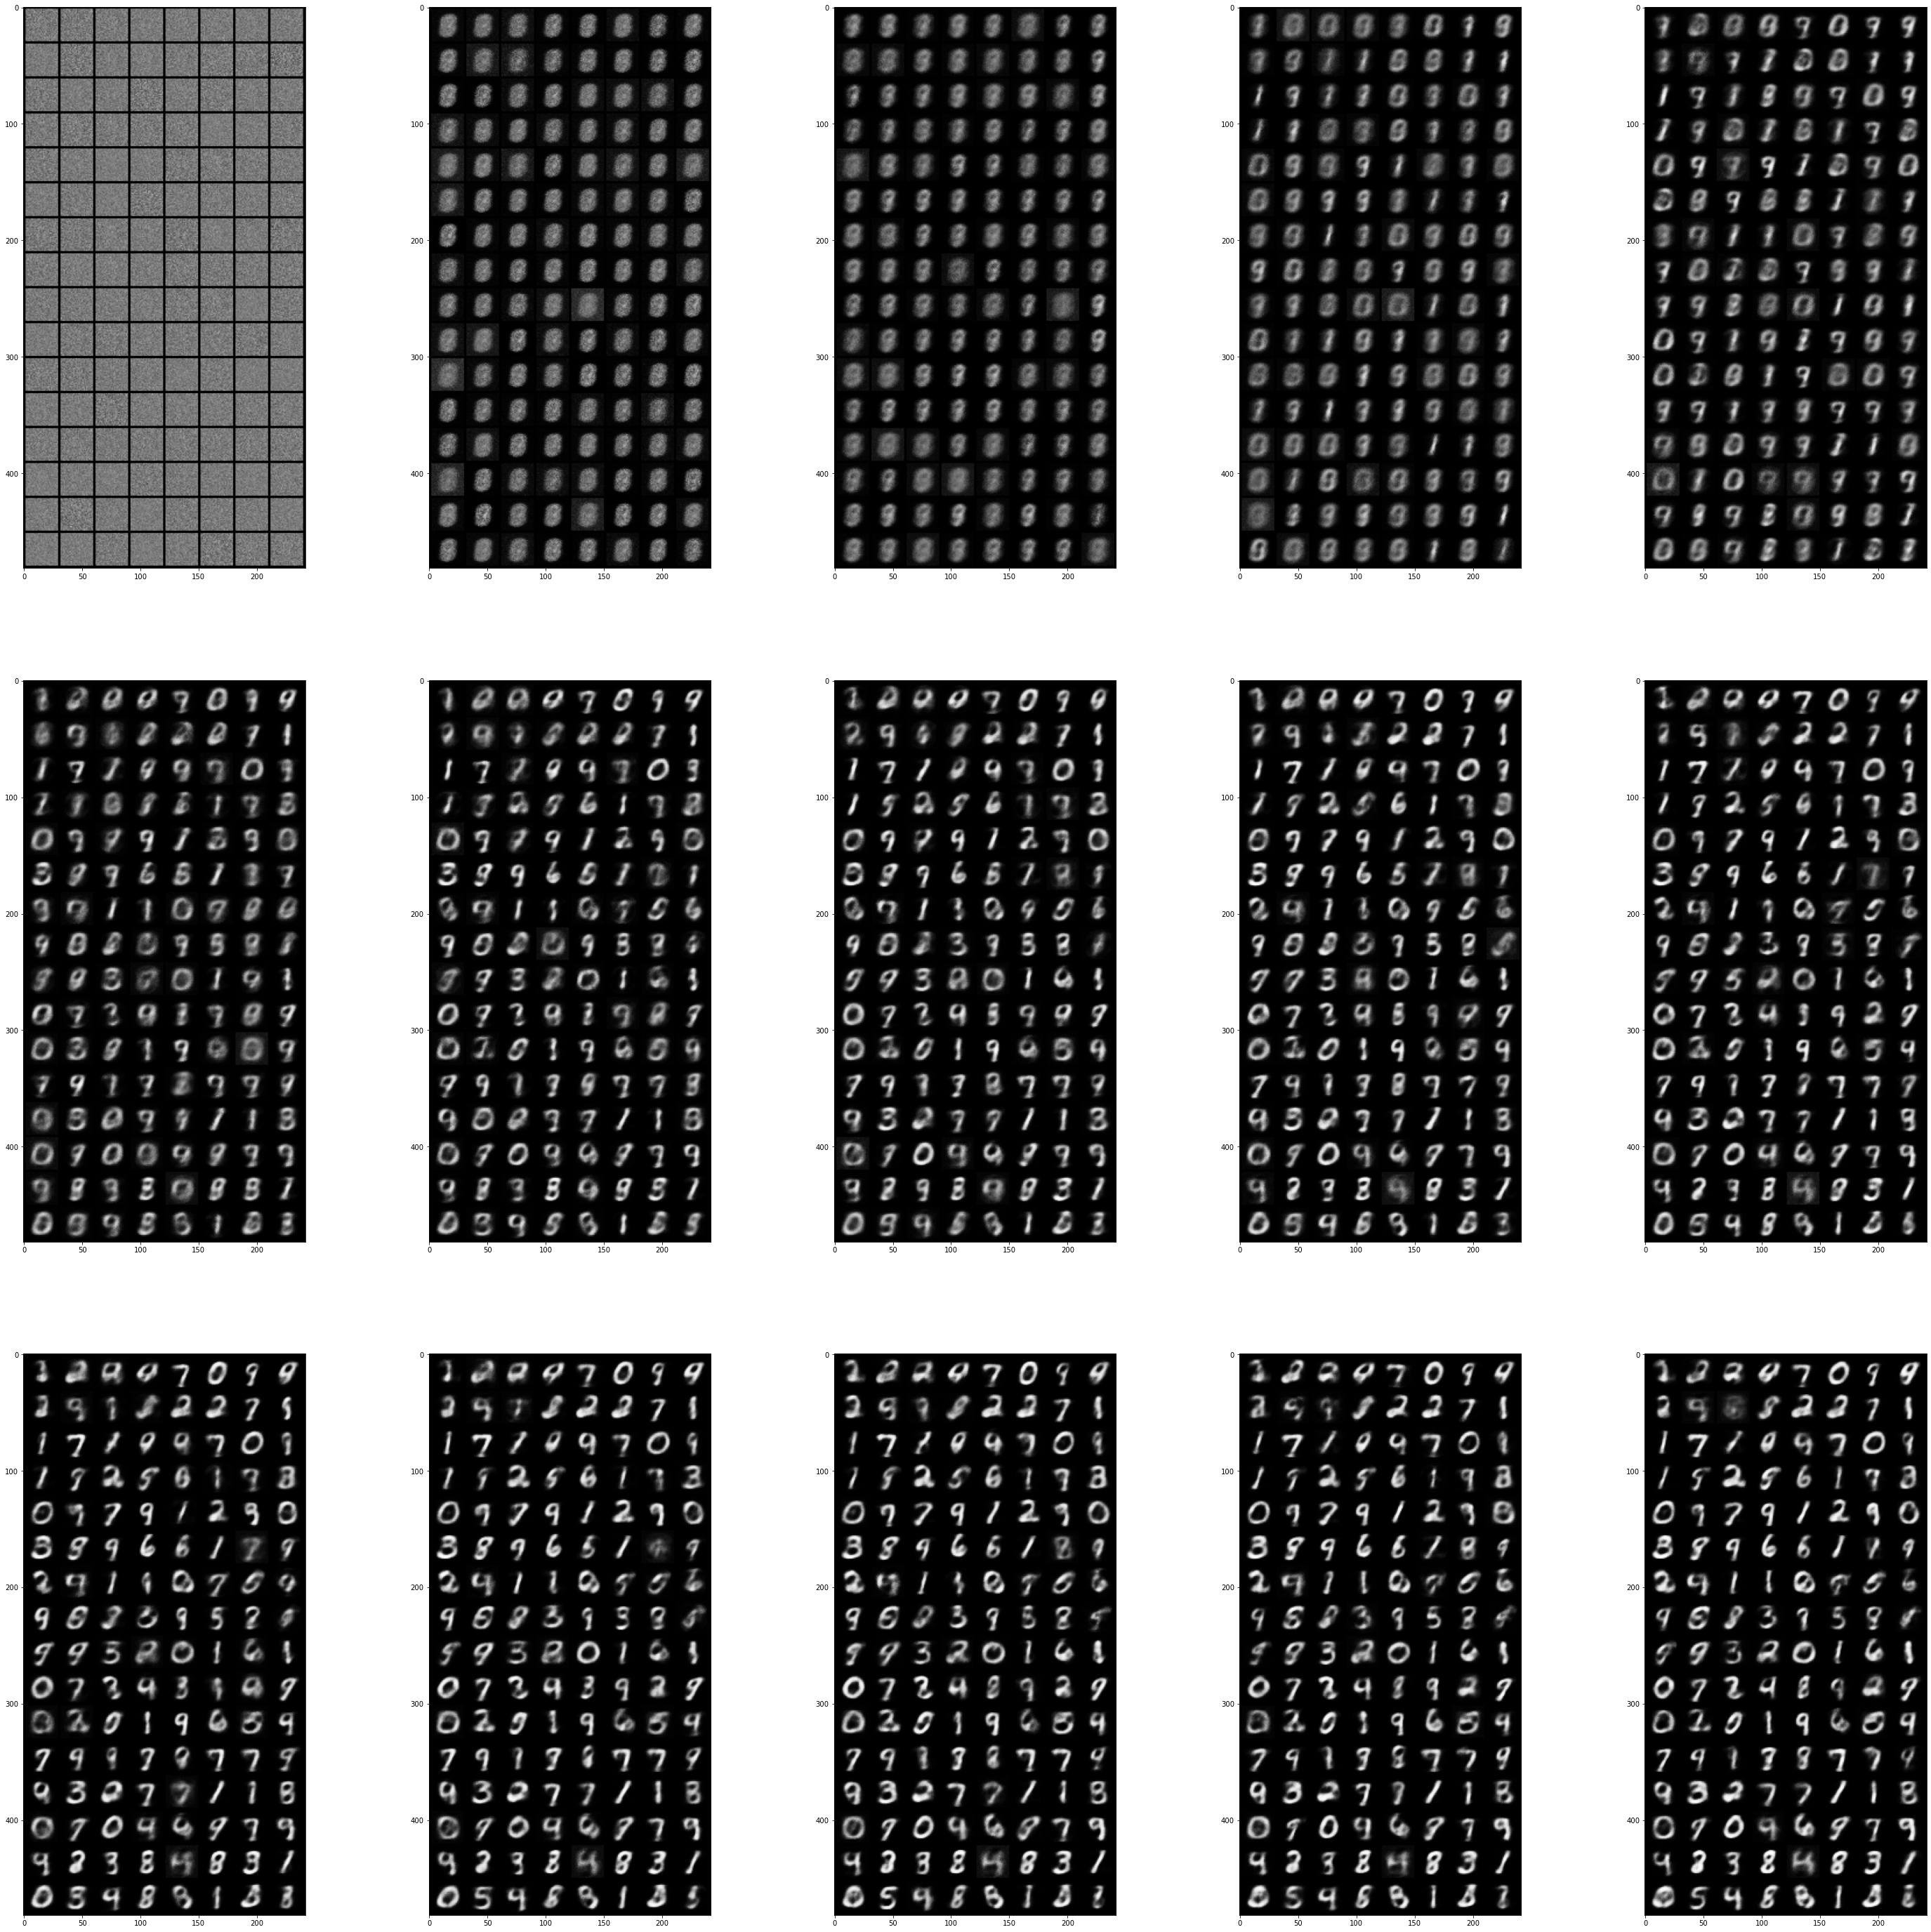

In [53]:
plt.figure(figsize=(50,50)) # specifying the overall grid size

for i in range(15):
    plt.subplot(3,5,i+1)    # the number of images in the grid is 3*5 (15)
    image = mpimg.imread(image_list[i])
    plt.imshow(image)

plt.show()